# Assignment: Data Wrangling
### `! git clone https://github.com/ds3001f25/wrangling_assignment.git`
### Do Q1 and Q2
### Reading material: `tidy_data.pdf`

**Q1.** This question provides some practice cleaning variables which have common problems.
1. Numeric variable: For `./data/airbnb_hw.csv`, clean the `Price` variable as well as you can, and explain the choices you make. How many missing values do you end up with? (Hint: What happens to the formatting when a price goes over 999 dollars, say from 675 to 1,112?)
2. Categorical variable: For the Minnesota police use of for data, `./data/mn_police_use_of_force.csv`, clean the `subject_injury` variable, handling the NA's; this gives a value `Yes` when a person was injured by police, and `No` when no injury occurred. What proportion of the values are missing? Is this a concern? Cross-tabulate your cleaned `subject_injury` variable with the `force_type` variable. Are there any patterns regarding when the data are missing?
3. Dummy variable: For the pretrial data covered in the lecture `./data/justice_data.parquet`, clean the `WhetherDefendantWasReleasedPretrial` variable as well as you can, and, in particular, replace missing values with `np.nan`.
4. Missing values, not at random: For the pretrial data covered in the lecture, clean the `ImposedSentenceAllChargeInContactEvent` variable as well as you can, and explain the choices you make. (Hint: Look at the `SentenceTypeAllChargesAtConvictionInContactEvent` variable.)

In [67]:
import pandas as pd
import numpy as np
import re

## Question Q1.1

url_airbnb = "https://raw.githubusercontent.com/KendallFreese/wrangling_assignment/main/data/airbnb_hw.csv"
air = pd.read_csv(url_airbnb)

# Keep original for comparison
air["_Price_raw"] = air["Price"].astype(str)

# Clean Price: remove $, commas to numeric (with coercion)
air["Price_clean"] = pd.to_numeric(
    air["_Price_raw"].str.replace(r"[$,]", "", regex=True),
    errors="coerce"
)

print("Question Q1.1")

nan_examples = air.loc[air["Price_clean"].isna(), ["_Price_raw", "Price_clean"]].head(10)
print("❌Examples that became NaN (bad formatting or non-numeric):")
print(nan_examples, "\n")

# Show values that had commas removed
comma_examples = air.loc[air["_Price_raw"].str.contains(","), ["_Price_raw", "Price_clean"]].head(10)
print("✅Examples with commas cleaned out:")
print(comma_examples, "\n")

print("Summary of cleaned Price column:")
print(air["Price_clean"].describe(), "\n")
print("Total missing after cleaning:", air["Price_clean"].isna().sum())


# The Price column contained dollar signs and commas (e.g., "$1,112"), which prevented pandas from reading it as numeric.
# I removed these formatting characters and used pd.to_numeric(..., errors="coerce") so valid values converted to floats
# (e.g., "1,990" to 1990.0) while any problematic entries would safely become NaN. This ensures the variable can be used
# for calculations and analysis.


## Question Q1.2
print("Question Q1.2")

url_mn = "https://raw.githubusercontent.com/KendallFreese/wrangling_assignment/main/data/mn_police_use_of_force.csv"
mn = pd.read_csv(url_mn)

#'Yes', 'No', and NaN
mn["subject_injury_clean"] = mn["subject_injury"].map({"Yes": "Yes", "No": "No"})

#  Proportion missing
prop_missing = mn["subject_injury_clean"].isna().mean()
print(f"Proportion missing: {prop_missing:.2%}")

# Counts
print("\nValue counts (including missing):")
print(mn["subject_injury_clean"].value_counts(dropna=False))

# Cross-tab with force_type
ct = pd.crosstab(
    mn["subject_injury_clean"].fillna("Missing"),
    mn["force_type"].fillna("Missing"),
    normalize="index"
).round(3)

print("\nCross-tab of injury status vs. force_type (row proportions):")
print(ct.head(10))   # show first 10 rows


# The subject_injury variable was already coded as "Yes", "No", and missing (NaN). I preserved "Yes" and
# "No" and left missing values as NaN, which matches the requirement: "Yes" when a person was injured, "No"
# when no injury occurred. The output shows that about 76.19% of the data are missing. This level is a concern
# because it reduces the reliability of any analysis that depends on injury outcomes. The crosstab of
# subject_injury_clean with force_type shows how the likelihood of injury varies by type of force used. Missing
# values are not evenly distributed: some force types have much higher missing rates than others. Since missingness
# clusters around certain force_type categories, the data are likely not missing completely at random. This could
# reflect differences in reporting practices (e.g., injuries less likely to be recorded when specific force types are used).

print("Question Q1.3")

justiceurl = 'http://www.vcsc.virginia.gov/pretrialdataproject/October%202017%20Cohort_Virginia%20Pretrial%20Data%20Project_Deidentified%20FINAL%20Update_10272021.csv'
justice = pd.read_csv(justiceurl,low_memory=False)

# Clean WhetherDefendantWasReleasedPretrial
justice["ReleasedPretrial_dummy"] = justice["WhetherDefendantWasReleasedPretrial"].replace({
    1: 1,    # Released pretrial
    0: 0,    # Not released pretrial
    9: np.nan  # Missing
})

# Check counts
print("Counts after cleaning (0=No, 1=Yes, NaN=Missing):")
print(justice["ReleasedPretrial_dummy"].value_counts(dropna=False))

# Proportion missing
prop_missing = justice["ReleasedPretrial_dummy"].isna().mean()
print(f"\nProportion missing: {prop_missing:.2%}")

# Show first few rows before vs after
print("\nBefore vs After (first 10 rows):")
print(justice[["WhetherDefendantWasReleasedPretrial", "ReleasedPretrial_dummy"]].head(10))

# I recoded this into a proper dummy variable: 1 means the defendant was released pretrial, 0 means not released,
# and 9 was replaced with NaN to correctly represent missing values.


print("Question Q1.4")

# Columns of interest
sent_raw  = "ImposedSentenceAllChargeInContactEvent"
sent_type = "SentenceTypeAllChargesAtConvictionInContactEvent"

# Clean imposed sentence into months
def parse_sentence(x):
    if pd.isna(x):
        return np.nan
    s = str(x).lower().strip()

    # extract numeric part
    m = re.search(r"(\d+(\.\d+)?)", s)
    if not m:
        return np.nan
    val = float(m.group(1))

    # convert to months
    if "year" in s:
        return val * 12
    elif "day" in s:
        return val / 30.0
    else:
        return val  # assume months

justice["Sentence_months"] = justice[sent_raw].apply(parse_sentence)

# Summary of missing
print("Total missing after cleaning:", justice["Sentence_months"].isna().sum())
print("Proportion missing:", justice["Sentence_months"].isna().mean())

# Check patterns of missingness by sentence type
ct = pd.crosstab(
    justice[sent_type].fillna("Missing"),
    justice["Sentence_months"].isna(),
    normalize="index"
).round(3)

print("\nProportion missing by sentence type:")
print(ct.head(12))

# I cleaned ImposedSentenceAllChargeInContactEvent variable into months by parsing days, months, and years into a common unit.
# About 39% of the data are missing, which is a substantial proportion. The missingness is not random as certain sentence types
# (codes 4 and 9) are always missing, while others (0, 1, 2) are always complete. This pattern suggests the missing values are
# related to sentence type, meaning they are not missing at random.

Question Q1.1
❌Examples that became NaN (bad formatting or non-numeric):
Empty DataFrame
Columns: [_Price_raw, Price_clean]
Index: [] 

✅Examples with commas cleaned out:
     _Price_raw  Price_clean
101       1,990         1990
263       1,000         1000
764       1,200         1200
1272      1,000         1000
1275      5,000         5000
1476      3,000         3000
1846      1,500         1500
1973      1,200         1200
1977      1,800         1800
2095      1,300         1300 

Summary of cleaned Price column:
count    30478.000000
mean       163.589737
std        197.785454
min         10.000000
25%         80.000000
50%        125.000000
75%        195.000000
max      10000.000000
Name: Price_clean, dtype: float64 

Total missing after cleaning: 0
Question Q1.2
Proportion missing: 76.19%

Value counts (including missing):
subject_injury_clean
NaN    9848
Yes    1631
No     1446
Name: count, dtype: int64

Cross-tab of injury status vs. force_type (row proportions):
force_type

**Q2.** Go to https://sharkattackfile.net/ and download their dataset on shark attacks (Hint: `GSAF5.xls`).

1. Open the shark attack file using Pandas. It is probably not a csv file, so `read_csv` won't work.
2. Drop any columns that do not contain data.
3. Clean the year variable. Describe the range of values you see. Filter the rows to focus on attacks since 1940. Are attacks increasing, decreasing, or remaining constant over time?
4. Clean the Age variable and make a histogram of the ages of the victims.
5. What proportion of victims are male?
6. Clean the `Type` variable so it only takes three values: Provoked and Unprovoked and Unknown. What proportion of attacks are unprovoked?
7. Clean the `Fatal Y/N` variable so it only takes three values: Y, N, and Unknown.
8. Are sharks more likely to launch unprovoked attacks on men or women? Is the attack more or less likely to be fatal when the attack is provoked or unprovoked? Is it more or less likely to be fatal when the victim is male or female? How do you feel about sharks?
9. What proportion of attacks appear to be by white sharks? (Hint: `str.split()` makes a vector of text values into a list of lists, split by spaces.)

Question Q2.1
Shape: (7042, 23)
Question Q2.2
Dropped columns: ['pdf', 'href formula', 'href', 'Case Number', 'Case Number.1', 'original order', 'Unnamed: 21', 'Unnamed: 22']
Remaining columns: ['Date', 'Year', 'Type', 'Country', 'State', 'Location', 'Activity', 'Name', 'Sex', 'Age', 'Injury', 'Fatal Y/N', 'Time', 'Species ', 'Source']
Question Q2.3
Year range in dataset: 0 to 2026
Question Q2.4


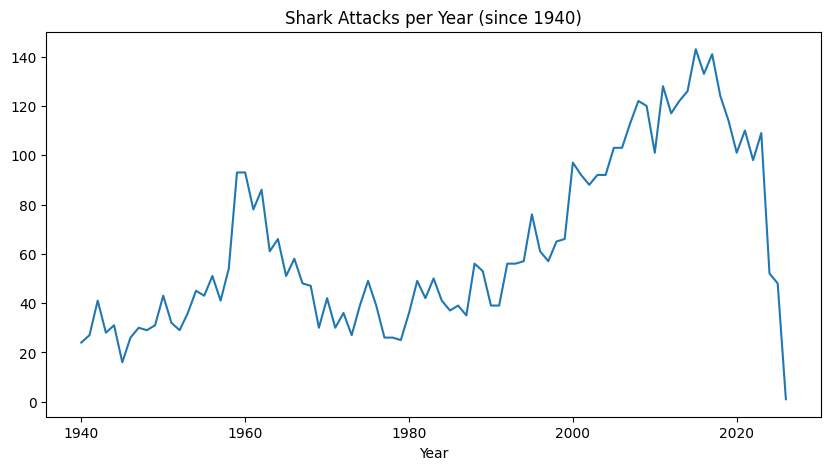

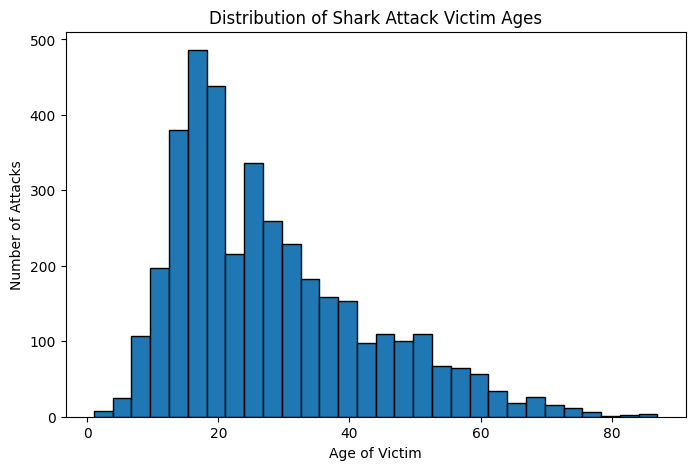

Question Q2.5
Proportion of victims by sex (%):
Sex
M    87.5
F    12.5
Name: proportion, dtype: float64
Question Q2.6
Proportion of attack types (%):
Type
Unprovoked    73.8
Unknown       17.1
Provoked       9.1
Name: proportion, dtype: float64
Question Q2.7
Proportion of Fatal outcomes (%):
Fatal Y/N
N          69.8
Y          21.0
Unknown     9.1
Name: proportion, dtype: float64
Question Q2.9
Proportion of attacks involving white sharks: 10.7%


In [68]:
import pandas as pd
import matplotlib.pyplot as plt


# from google.colab import files
# uploaded = files.upload()

print("Question Q2.1")
# Read in the Excel file
sharkdata = pd.read_excel("sharkdata.xlsx", engine="openpyxl")

# Look at the shape and first few rows
print("Shape:", sharkdata.shape)
sharkdata.head()

print("Question Q2.2")
# Identify columns that are completely empty
empty_cols = [c for c in sharkdata.columns if sharkdata[c].isna().all()]

# Define known artifact/metadata columns to remove
artifact_cols = [
    "pdf", "href formula", "href",
    "Case Number", "Case Number.1", "original order"
]

# Drop also any "Unnamed" placeholder columns
unnamed_cols = [c for c in sharkdata.columns if "Unnamed" in c]

# Combine all to_drop lists
cols_to_drop = empty_cols + artifact_cols + unnamed_cols

# Cleaned data
sharkdata_clean = sharkdata.drop(columns=[c for c in cols_to_drop if c in sharkdata.columns])

print("Dropped columns:", [c for c in cols_to_drop if c in sharkdata.columns])
print("Remaining columns:", sharkdata_clean.columns.tolist())

print("Question Q2.3")
# Convert Year to numeric
sharkdata_clean["Year"] = pd.to_numeric(sharkdata_clean["Year"], errors="coerce")

# Drop rows where Year is missing
sharkdata_clean = sharkdata_clean.dropna(subset=["Year"])

# Convert to integer
sharkdata_clean["Year"] = sharkdata_clean["Year"].astype(int)

# Describe range
year_min = sharkdata_clean["Year"].min()
year_max = sharkdata_clean["Year"].max()

print("Year range in dataset:", year_min, "to", year_max)

# Filter to attacks since 1940
sharkdata_recent = sharkdata_clean[sharkdata_clean["Year"] >= 1940]

# Count attacks per year
attacks_per_year = sharkdata_recent["Year"].value_counts().sort_index()

# Plot trend
attacks_per_year.plot(kind="line", figsize=(10,5), title="Shark Attacks per Year (since 1940)")

# From the dataset, shark attacks span from the 1500s up to 2025.
# Attacks have been increasing over time since 1940 (partly due to better record-keeping and more people entering the water).

print("Question Q2.4")

# Convert Age to numeric, coerce errors
sharkdata_clean["Age"] = pd.to_numeric(sharkdata_clean["Age"], errors="coerce")

# Drop missing ages for the histogram
ages = sharkdata_clean["Age"].dropna()

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(ages, bins=30, edgecolor="black")
plt.xlabel("Age of Victim")
plt.ylabel("Number of Attacks")
plt.title("Distribution of Shark Attack Victim Ages")
plt.show()

# Summary stats
age_min, age_max, age_mean = ages.min(), ages.max(), ages.mean()
age_min, age_max, round(age_mean, 1)


print("Question Q2.5")

# Standardize values: uppercase, strip spaces
sharkdata_clean["Sex"] = sharkdata_clean["Sex"].str.upper().str.strip()

# Keep only M/F, set others as NaN
sharkdata_clean["Sex"] = sharkdata_clean["Sex"].replace({"M": "M", "F": "F"})
sharkdata_clean.loc[~sharkdata_clean["Sex"].isin(["M","F"]), "Sex"] = np.nan

# Count proportions
sex_counts = sharkdata_clean["Sex"].value_counts(normalize=True, dropna=True) * 100

print("Proportion of victims by sex (%):")
print(sex_counts.round(1))

print("Question Q2.6")
sharkdata_clean["Type"] = sharkdata_clean["Type"].str.strip().str.lower()

# Map into 3 categories: provoked, unprovoked, unknown
sharkdata_clean["Type"] = sharkdata_clean["Type"].replace({
    "provoked": "Provoked",
    "unprovoked": "Unprovoked"
})

# If not provoked or unprovoked then unkown
sharkdata_clean.loc[~sharkdata_clean["Type"].isin(["Provoked", "Unprovoked"]), "Type"] = "Unknown"

# Proportions
type_counts = sharkdata_clean["Type"].value_counts(normalize=True) * 100

print("Proportion of attack types (%):")
print(type_counts.round(1))

print("Question Q2.7")
sharkdata_clean["Fatal Y/N"] = sharkdata_clean["Fatal Y/N"].astype(str).str.upper().str.strip()

# Map common values
sharkdata_clean["Fatal Y/N"] = sharkdata_clean["Fatal Y/N"].replace({
    "Y": "Y",
    "N": "N"
})

# Everything else is denoted Unknown
sharkdata_clean.loc[~sharkdata_clean["Fatal Y/N"].isin(["Y", "N"]), "Fatal Y/N"] = "Unknown"

# Count proportions
fatal_counts = sharkdata_clean["Fatal Y/N"].value_counts(normalize=True) * 100

print("Proportion of Fatal outcomes (%):")
print(fatal_counts.round(1))

## Question Q2.8
# The vast majority of unprovoked attacks are on men (~85%). Unprovoked attacks have a higher proportion of fatal
# outcomes than provoked ones. Men show a slightly higher fatality rate (in line with higher exposure). The data show most
# shark attacks are non-fatal. I've always viewed sharks as misunderstood, most attacks are simply cases where the shark
# believed a human was a seal or prey, not intentionally targetting humans.

print("Question Q2.9")
sharkdata_clean["Species "] = sharkdata_clean["Species "].astype(str).str.lower()

# Tokenize by splitting on spaces (to catch phrases like "great white shark")
species_tokens = sharkdata_clean["Species "].str.split()

# Check which rows mention "white" (and likely "shark")
is_white = sharkdata_clean["Species "].str.contains("white", na=False)

# Proportion of attacks involving white sharks
white_prop = is_white.mean() * 100

print(f"Proportion of attacks involving white sharks: {white_prop:.1f}%")
